In [1]:
# Import library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import re
warnings.filterwarnings('ignore')

# Set random seed untuk reproduksibilitas
np.random.seed(42)
tf.random.set_seed(42)



# === BUSINESS UNDERSTANDING ===
'''
Industri hiburan, khususnya platform streaming film dan serial, membutuhkan sistem rekomendasi yang efektif untuk:
1. Meningkatkan engagement pengguna melalui rekomendasi film yang relevan
2. Mengurangi churn rate dengan memastikan pengguna menemukan konten yang mereka sukai
3. Meningkatkan konversi dan kepuasan penonton dengan personalisasi
4. Membantu pengguna menavigasi katalog film yang besar (mengatasi paradox of choice)

Collaborative filtering memanfaatkan pola kolektif dari perilaku dan preferensi pengguna untuk menghasilkan
rekomendasi yang dipersonalisasi, tanpa memerlukan informasi konten eksplisit.
'''

# === PROBLEM STATEMENTS ===
'''
1. Bagaimana memprediksi rating film yang belum pernah ditonton oleh pengguna?
2. Bagaimana memberikan rekomendasi film yang relevan dan dipersonalisasi untuk pengguna berdasarkan histori rating-nya?
3. Bagaimana menangani sparse matrix dalam data rating pengguna-film yang sebagian besar elemen-nya kosong?
4. Bagaimana mengatasi cold-start problem untuk pengguna baru atau film baru dalam sistem?
'''

# === GOALS ===
'''
1. Mengembangkan model collaborative filtering yang dapat memprediksi rating film dengan error rata-rata (MAE) < 0.8 pada skala 10-poin
2. Menghasilkan daftar top-10 rekomendasi film untuk setiap pengguna dengan Precision@10 > 0.3 dan NDCG@10 > 0.5
3. Membandingkan performa pendekatan Matrix Factorization tradisional dengan Neural Collaborative Filtering
4. Mengevaluasi performa model menggunakan metrik yang relevan untuk rekomendasi (MAE, RMSE, Precision@k, Recall@k, NDCG@k)
'''

# === SOLUTION STATEMENTS ===
'''
1. Menggunakan pendekatan matrix factorization melalui embedding user dan item untuk mempelajari representasi laten:
   - Mengekstrak pola tersembunyi (latent factors) yang menjelaskan preferensi pengguna dan karakteristik film
   - Menurunkan dimensionalitas data dari sparse user-item matrix menjadi dense embedding

2. Mengimplementasikan dua pendekatan untuk perbandingan:
   a. Matrix Factorization (MF): Menggunakan dot product antara user dan item embedding untuk prediksi rating
      - Model baseline yang efisien dan interpretable
      - Mengandalkan interaksi linear antara user dan item factors
   
   b. Neural Collaborative Filtering (NeuMF): Menggabungkan pendekatan MF dengan Multi-Layer Perceptron (MLP)
      - Menangkap interaksi non-linear antara user dan item
      - Meningkatkan kapasitas model dalam memodelkan pola kompleks
      - Menggunakan neural network untuk mempelajari fungsi scoring dari representasi latent

3. Menggunakan TensorFlow sebagai kerangka kerja utama untuk membangun dan melatih model, dengan:
   - Regularisasi untuk mencegah overfitting
   - Early stopping untuk training yang efisien
   - Learning rate scheduler untuk konvergensi yang lebih baik
'''

# 1. Data Understanding

Saving 16k_Movies.csv to 16k_Movies.csv
Berhasil memuat dataset!
Dataset Film (5 baris pertama):
   Unnamed: 0                     Title  Release Date  \
0           0            Dekalog (1988)  Mar 22, 1996   
1           1         Three Colors: Red  Nov 23, 1994   
2           2            The Conformist  Oct 22, 1970   
3           3               Tokyo Story  Mar 13, 1972   
4           4  The Leopard (re-release)  Aug 13, 2004   

                                         Description  Rating  \
0  This masterwork by Krzysztof Kieślowski is one...     7.4   
1  Krzysztof Kieslowski closes his Three Colors t...     8.3   
2  Set in Rome in the 1930s, this re-release of B...     7.3   
3  Yasujiro Ozu’s Tokyo Story follows an aging co...     8.1   
4  Set in Sicily in 1860, Luchino Visconti's spec...     7.8   

  No of Persons Voted           Directed by  \
0                 118  Krzysztof Kieslowski   
1                 241  Krzysztof Kieslowski   
2                 106   Bernardo B

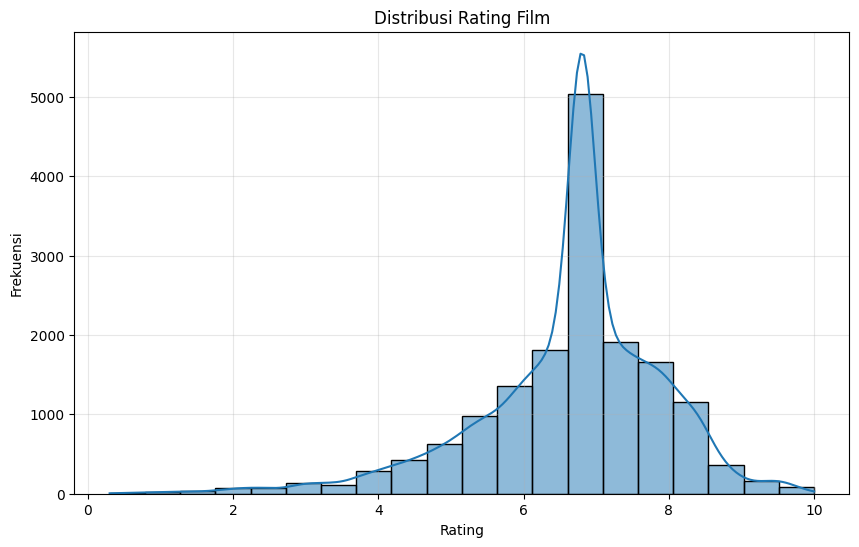


Tahun rilis yang kosong diisi dengan nilai median: 2011


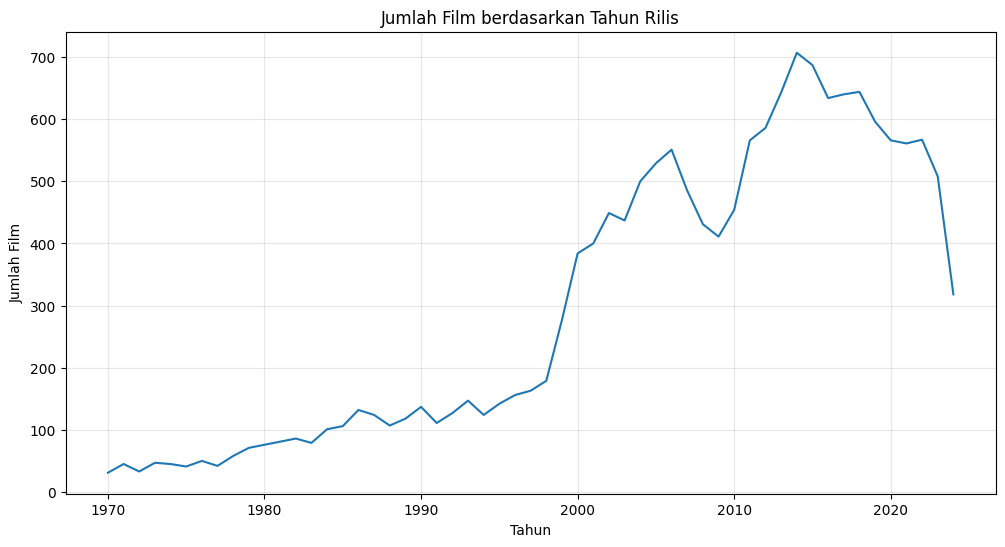

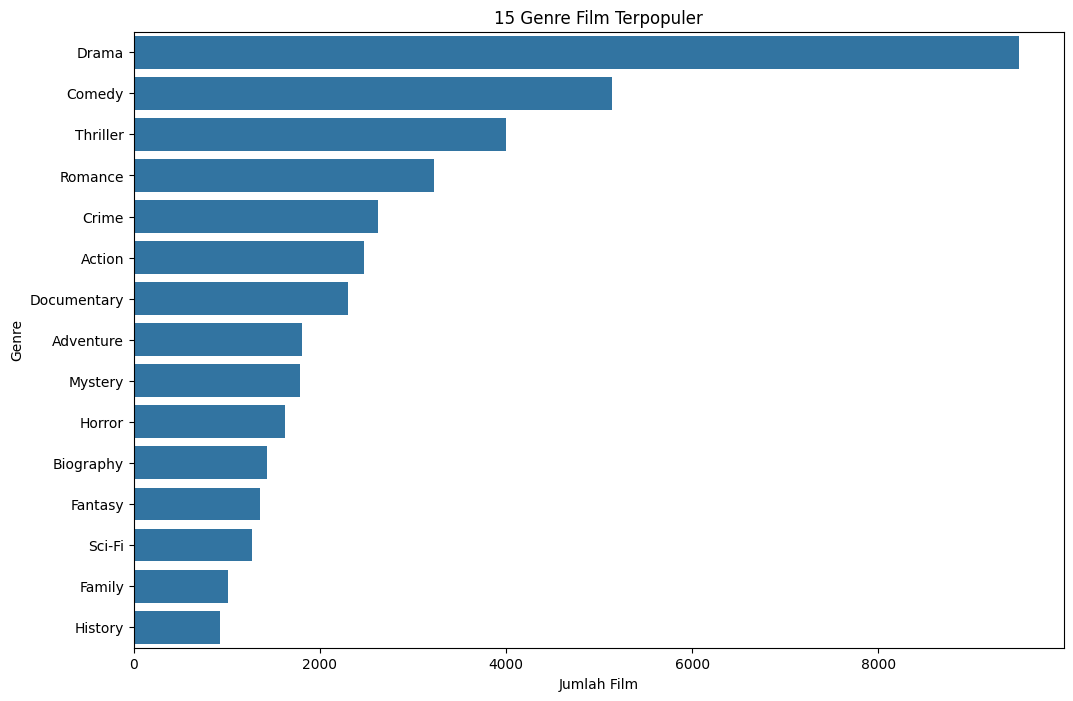

Dataset Rating Sintetis:
   user_id  movie_id    rating
0      102       571  6.888370
1      435      7330  5.671884
2      348      1291  6.789533
3      270      9380  8.968707
4      106     14724  5.557375
Jumlah rating: 397205
Jumlah pengguna unik: 500
Jumlah film unik: 16290


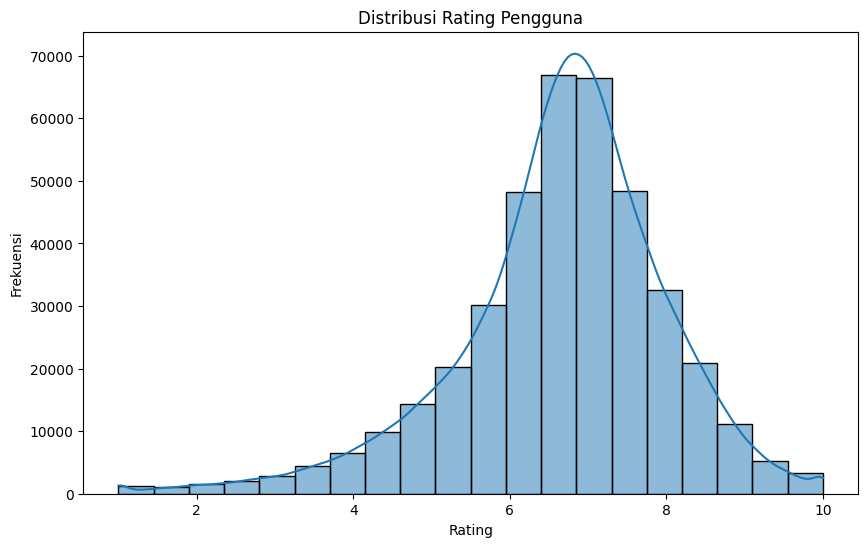

Densitas matrix rating: 0.0488
Sparsity matrix rating: 0.9512


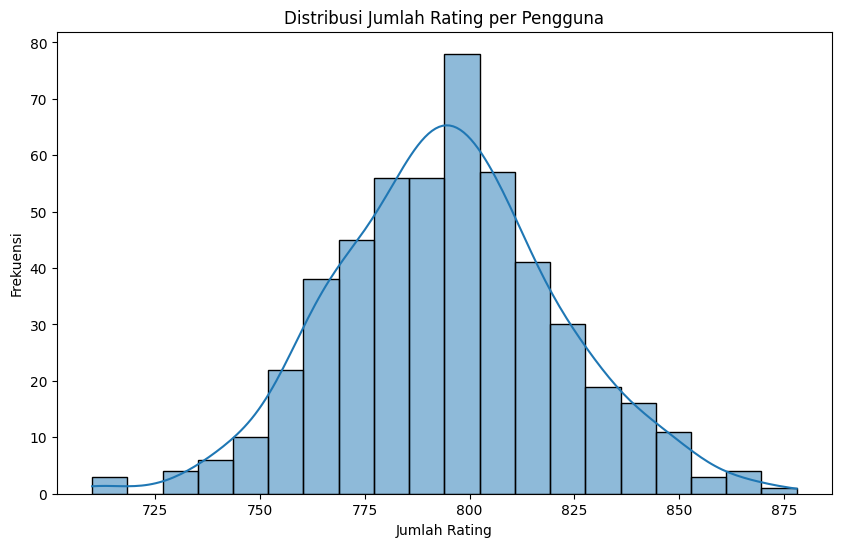

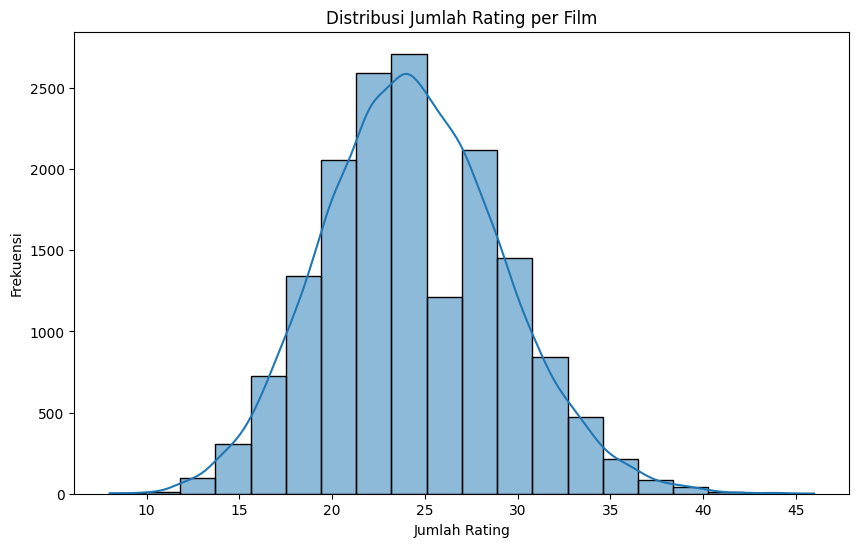


Data yang sudah dibersihkan berhasil disimpan ke CSV!


In [2]:
# Load dataset film
try:
    from google.colab import files
    uploaded = files.upload()  # Upload file 16k_Movies.csv

    # Load dataset
    movies_df = pd.read_csv('16k_Movies.csv')
    print("Berhasil memuat dataset!")
except Exception as e:
    print(f"Error saat memuat file: {e}")
    # Bisa menambahkan fallback jika upload gagal
    # movies_df = pd.read_csv('URL_TO_GITHUB_RAW_FILE')

# Tampilkan 5 baris pertama
print("Dataset Film (5 baris pertama):")
print(movies_df.head())

# Informasi dataset
print("\nInformasi Dataset Film:")
print(movies_df.info())

# Statistik deskriptif
print("\nStatistik Deskriptif:")
print(movies_df.describe())

# Analisis missing values
print("\nJumlah Missing Values per Kolom:")
missing_values = movies_df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")
print(f"Persentase missing values: {(missing_values.sum() / (movies_df.shape[0] * movies_df.shape[1])) * 100:.2f}%")

# Penanganan missing values untuk kolom penting
print("\n--- Penanganan Missing Values ---")

# 1. Rating - isi dengan median
median_rating = movies_df['Rating'].median()
movies_df['Rating'] = movies_df['Rating'].fillna(median_rating)
print(f"Rating yang kosong diisi dengan nilai median: {median_rating}")

# 2. No of Persons Voted - isi dengan 0
movies_df['No of Persons Voted'] = movies_df['No of Persons Voted'].fillna(0)
print("Jumlah voters yang kosong diisi dengan 0")

# 3. Genres - isi dengan 'Unknown'
movies_df['Genres'] = movies_df['Genres'].fillna('Unknown')
print("Genre yang kosong diisi dengan 'Unknown'")

# 4. Description - isi dengan string kosong
movies_df['Description'] = movies_df['Description'].fillna('No description available')
print("Deskripsi yang kosong diisi dengan 'No description available'")

# 5. Director dan Writer - isi dengan 'Unknown'
movies_df['Directed by'] = movies_df['Directed by'].fillna('Unknown')
movies_df['Written by'] = movies_df['Written by'].fillna('Unknown')
print("Sutradara dan penulis yang kosong diisi dengan 'Unknown'")

# 6. Duration - isi dengan median
if 'Duration' in movies_df.columns:
    # Ekstrak nilai numerik dari duration jika dalam format 'X h Y m'
    def extract_minutes(duration_str):
        if pd.isna(duration_str):
            return np.nan

        total_minutes = 0
        # Cari pola 'X h'
        hour_match = re.search(r'(\d+)\s*h', str(duration_str))
        if hour_match:
            total_minutes += int(hour_match.group(1)) * 60

        # Cari pola 'Y m'
        min_match = re.search(r'(\d+)\s*m', str(duration_str))
        if min_match:
            total_minutes += int(min_match.group(1))

        return total_minutes if total_minutes > 0 else np.nan

    # Ekstrak durasi dalam menit
    movies_df['Duration_minutes'] = movies_df['Duration'].apply(extract_minutes)

    # Isi nilai yang kosong dengan median
    median_duration = movies_df['Duration_minutes'].median()
    movies_df['Duration_minutes'] = movies_df['Duration_minutes'].fillna(median_duration)
    print(f"Durasi yang kosong diisi dengan nilai median: {median_duration} menit")

# Verifikasi hasil penanganan missing values
print("\nJumlah Missing Values Setelah Penanganan:")
print(movies_df[['Title', 'Rating', 'No of Persons Voted', 'Genres', 'Description', 'Directed by', 'Written by']].isnull().sum())

# Analisis distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['Rating'], bins=20, kde=True)
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.grid(alpha=0.3)
plt.show()

# Analisis tahun rilis film dengan penanganan missing values
# Ekstrak tahun dari 'Release Date'
movies_df['Release Year'] = movies_df['Release Date'].str.extract(r'(\d{4})')
# Konversi ke numeric dan tangani missing values
movies_df['Release Year'] = pd.to_numeric(movies_df['Release Year'], errors='coerce')
# Isi missing values dengan median tahun
median_year = movies_df['Release Year'].median()
movies_df['Release Year'] = movies_df['Release Year'].fillna(median_year)
movies_df['Release Year'] = movies_df['Release Year'].astype(int)  # Konversi ke integer

print(f"\nTahun rilis yang kosong diisi dengan nilai median: {int(median_year)}")

# Visualisasi tahun rilis
plt.figure(figsize=(12, 6))
year_counts = movies_df['Release Year'].value_counts().sort_index()
# Filter tahun yang valid (menghindari tahun yang terlalu kecil atau besar)
valid_years = year_counts[(year_counts.index >= 1900) & (year_counts.index <= 2025)]
valid_years.plot(kind='line')
plt.title('Jumlah Film berdasarkan Tahun Rilis')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.grid(True, alpha=0.3)
plt.show()

# Analisis genre dengan penanganan format yang berbeda
# Pisahkan genre yang berbentuk string dengan koma menjadi list
genre_counts = {}
for genres in movies_df['Genres']:
    if isinstance(genres, str):
        for genre in genres.split(','):
            genre = genre.strip()
            if genre and genre != 'Unknown':  # Skip empty atau Unknown
                if genre in genre_counts:
                    genre_counts[genre] += 1
                else:
                    genre_counts[genre] = 1

# Visualisasi genre terpopuler
plt.figure(figsize=(12, 8))
sorted_genres = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)[:15])
sns.barplot(x=list(sorted_genres.values()), y=list(sorted_genres.keys()))
plt.title('15 Genre Film Terpopuler')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()

# Membuat dataset rating sintetis dengan penanganan missing values yang lebih baik
# Filter film yang sudah memiliki rating (tidak perlu karena kita sudah handle missing values)
movies_subset = movies_df[['Title', 'Rating', 'Genres']].reset_index(drop=True)
movies_subset['movie_id'] = movies_subset.index

# Buat dataframe pengguna sintetis (500 pengguna)
num_users = 500
num_movies = len(movies_subset)

# Buat matrix rating sintetis dengan sparsity tinggi (95% kosong)
sparsity = 0.95
num_ratings = int(num_users * num_movies * (1 - sparsity))

# Buat data rating sintetis dengan manajemen error yang lebih baik
np.random.seed(42)  # Untuk reproducibility
user_ids = np.random.choice(num_users, num_ratings)
movie_ids = np.random.choice(num_movies, num_ratings)
ratings = []

for i in range(num_ratings):
    try:
        # Basis rating dari rating film sebenarnya + noise
        base_rating = movies_subset.loc[movie_ids[i], 'Rating']
        # Pastikan base_rating valid
        if pd.isna(base_rating):
            user_rating = np.random.uniform(5, 8)  # Rating acak antara 5-8 jika basis tidak valid
        else:
            noise = np.random.normal(0, 0.5)  # Kurangi variance noise
            user_rating = base_rating + noise
            # Pastikan rating dalam skala 1-10
            user_rating = max(1, min(10, user_rating))
        ratings.append(user_rating)
    except Exception as e:
        # Jika terjadi error, gunakan rating acak
        ratings.append(np.random.uniform(1, 10))
        print(f"Error saat membuat rating sintetis: {e}")

# Buat dataframe ratings
ratings_df = pd.DataFrame({
    'user_id': user_ids,
    'movie_id': movie_ids,
    'rating': ratings
})

# Hapus duplikat (user_id, movie_id)
ratings_df = ratings_df.drop_duplicates(['user_id', 'movie_id'])
# Reset index setelah drop_duplicates
ratings_df.reset_index(drop=True, inplace=True)

print("Dataset Rating Sintetis:")
print(ratings_df.head())
print(f"Jumlah rating: {len(ratings_df)}")
print(f"Jumlah pengguna unik: {ratings_df['user_id'].nunique()}")
print(f"Jumlah film unik: {ratings_df['movie_id'].nunique()}")

# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

# Analisis densitas matrix rating (sparsity)
density = len(ratings_df) / (ratings_df['user_id'].nunique() * ratings_df['movie_id'].nunique())
sparsity = 1 - density
print(f"Densitas matrix rating: {density:.4f}")
print(f"Sparsity matrix rating: {sparsity:.4f}")

# Visualisasi jumlah rating per pengguna
plt.figure(figsize=(10, 6))
ratings_per_user = ratings_df.groupby('user_id').size()
sns.histplot(ratings_per_user, bins=20, kde=True)
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi jumlah rating per film
plt.figure(figsize=(10, 6))
ratings_per_movie = ratings_df.groupby('movie_id').size()
sns.histplot(ratings_per_movie, bins=20, kde=True)
plt.title('Distribusi Jumlah Rating per Film')
plt.xlabel('Jumlah Rating')
plt.ylabel('Frekuensi')
plt.show()

# Simpan data yang sudah dibersihkan untuk modelling
try:
    movies_cleaned = movies_df.copy()
    movies_cleaned.to_csv('movies_cleaned.csv', index=False)
    ratings_df.to_csv('ratings_synthetic.csv', index=False)
    print("\nData yang sudah dibersihkan berhasil disimpan ke CSV!")
except Exception as e:
    print(f"Error saat menyimpan data: {e}")

# 2. Data Preparation

In [3]:
# Normalisasi rating (skala 0-1)
ratings_df['rating_normalized'] = ratings_df['rating'] / 10.0

# Split dataset menjadi train, validation, dan test set
# Strategi 1: Random split
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Ukuran train set: {len(train_data)}")
print(f"Ukuran validation set: {len(val_data)}")
print(f"Ukuran test set: {len(test_data)}")

# Strategi 2: Leave-one-out untuk evaluasi rekomendasi
# Untuk setiap pengguna, simpan satu rating untuk test
def leave_one_out_split(df):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()

    for user_id, user_data in df.groupby('user_id'):
        if len(user_data) > 2:  # User dengan minimal 2 rating
            user_test = user_data.sample(1)  # Ambil 1 rating untuk test
            user_train = user_data.drop(user_test.index)

            train_set = pd.concat([train_set, user_train])
            test_set = pd.concat([test_set, user_test])

    return train_set, test_set

# Untuk evaluasi rekomendasi top-N
train_loo, test_loo = leave_one_out_split(ratings_df)
print(f"Leave-one-out train set: {len(train_loo)}")
print(f"Leave-one-out test set: {len(test_loo)}")

# Fungsi untuk membuat TF Dataset
def create_tf_dataset(user_ids, movie_ids, ratings, batch_size=64, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'user_input': user_ids,
        'movie_input': movie_ids
    }, ratings))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(user_ids))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

# Buat dataset untuk training
train_dataset = create_tf_dataset(
    train_data['user_id'].values,
    train_data['movie_id'].values,
    train_data['rating_normalized'].values
)

val_dataset = create_tf_dataset(
    val_data['user_id'].values,
    val_data['movie_id'].values,
    val_data['rating_normalized'].values
)

test_dataset = create_tf_dataset(
    test_data['user_id'].values,
    test_data['movie_id'].values,
    test_data['rating_normalized'].values,
    shuffle=False
)

# Dapatkan jumlah users dan movies
num_users = ratings_df['user_id'].max() + 1  # +1 karena index dimulai dari 0
num_movies = ratings_df['movie_id'].max() + 1
print(f"Jumlah users: {num_users}")
print(f"Jumlah movies: {num_movies}")

Ukuran train set: 254211
Ukuran validation set: 63553
Ukuran test set: 79441
Leave-one-out train set: 396705
Leave-one-out test set: 500
Jumlah users: 500
Jumlah movies: 16290


# 3. Modeling

## Model 1: Matrix Factorization dengan Embedding

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     25,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    814,500 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 839,500 (3.20 MB)

 Trainable params: 839,500 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.3372 - mean_absolute_error: 0.5178 - val_loss: 0.0121 - val_mean_absolute_error: 0.0691 - learning_rate: 0.0010
Epoch 2/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0124 - mean_absolute_error: 0.0708 - val_loss: 0.0133 - val_mean_absolute_error: 0.0732 - learning_rate: 0.0010
Epoch 3/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0672 - val_loss: 0.0128 - val_mean_absolute_error: 0.0700 - learning_rate: 0.0010
Epoch 4/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0621 - val_loss: 0.0125 - val_mean_absolute_error: 0.0678 - learning_rate: 0.0010
Epoch 5/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0085 - mean_absolute_error: 0.0441 - val_loss: 0.0084 - val_mean_absolute_error: 0.0465 - learning_rate: 2.0000e-04
Epoch 6/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0067 - mean_absolute_error: 0.0329 - val_loss:

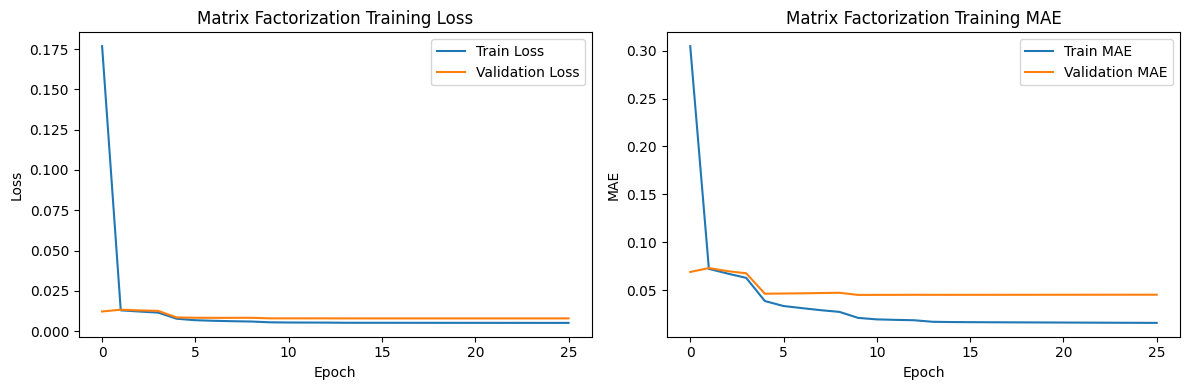

In [4]:
# Model 1: Matrix Factorization dengan Embedding
def create_mf_model(num_users, num_movies, embedding_size=50):
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    movie_input = tf.keras.layers.Input(shape=(1,), name='movie_input')

    # Embedding layers
    user_embedding = tf.keras.layers.Embedding(
        num_users, embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='user_embedding')(user_input)
    movie_embedding = tf.keras.layers.Embedding(
        num_movies, embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='movie_embedding')(movie_input)

    # Flatten embeddings
    user_vector = tf.keras.layers.Flatten()(user_embedding)
    movie_vector = tf.keras.layers.Flatten()(movie_embedding)

    # Dot product untuk prediksi rating
    dot_product = tf.keras.layers.Dot(axes=1)([user_vector, movie_vector])

    # Model
    model = tf.keras.Model(inputs=[user_input, movie_input], outputs=dot_product)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model

# Training MF model
mf_model = create_mf_model(num_users, num_movies, embedding_size=50)
mf_model.summary()

# Tambahkan callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Train model
mf_history = mf_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mf_history.history['loss'], label='Train Loss')
plt.plot(mf_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Matrix Factorization Training Loss')

plt.subplot(1, 2, 2)
plt.plot(mf_history.history['mean_absolute_error'], label='Train MAE')
plt.plot(mf_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Matrix Factorization Training MAE')
plt.tight_layout()
plt.show()

## Model 2: Neural Collaborative Filtering (NeuMF)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_user_embedding  │ (None, 1, 32)     │     16,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_movie_embedding │ (None, 1, 32)     │    521,280 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32)        │          0 │ mlp_user_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32)        │          0 │ mlp_movie_embedd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mf_user_embedding   │ (None, 1, 50)     │     25,000 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mf_movie_embedding  │ (None, 1, 50)     │    814,500 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ mf_user_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ mf_movie_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50)        │          0 │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 66)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         67 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,383,615 (5.28 MB)

 Trainable params: 1,383,615 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 0.0301 - mean_absolute_error: 0.1102 - val_loss: 0.0048 - val_mean_absolute_error: 0.0507 - learning_rate: 0.0010
Epoch 2/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.0044 - mean_absolute_error: 0.0483 - val_loss: 0.0045 - val_mean_absolute_error: 0.0480 - learning_rate: 0.0010
Epoch 3/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0043 - mean_absolute_error: 0.0464 - val_loss: 0.0048 - val_mean_absolute_error: 0.0493 - learning_rate: 0.0010
Epoch 4/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0041 - mean_absolute_error: 0.0446 - val_loss: 0.0047 - val_mean_absolute_error: 0.0484 - learning_rate: 0.0010
Epoch 5/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0422 - val_loss: 0.0046 - val_mean_absolute_error: 0.0475 - learning_rate: 0.0010
Epoch 6/30
3973/3973 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0030 - mean_absolute_error: 0.0360 - val_loss: 0.0

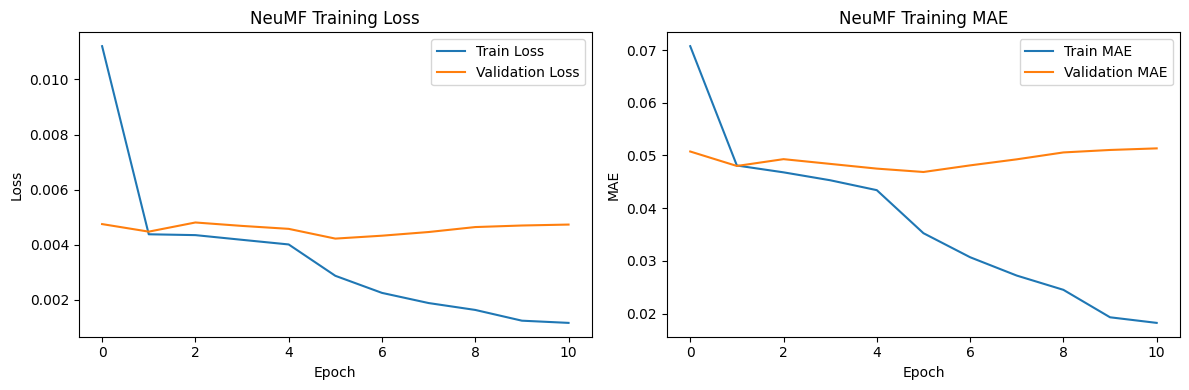

In [5]:
# Model 2: Neural Collaborative Filtering (NeuMF)
def create_neumf_model(num_users, num_movies, mf_embedding_size=50, mlp_embedding_size=32):
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    movie_input = tf.keras.layers.Input(shape=(1,), name='movie_input')

    # MF part
    mf_user_embedding = tf.keras.layers.Embedding(
        num_users, mf_embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='mf_user_embedding')(user_input)
    mf_movie_embedding = tf.keras.layers.Embedding(
        num_movies, mf_embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='mf_movie_embedding')(movie_input)

    mf_user_latent = tf.keras.layers.Flatten()(mf_user_embedding)
    mf_movie_latent = tf.keras.layers.Flatten()(mf_movie_embedding)

    mf_vector = tf.keras.layers.Multiply()([mf_user_latent, mf_movie_latent])

    # MLP part
    mlp_user_embedding = tf.keras.layers.Embedding(
        num_users, mlp_embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='mlp_user_embedding')(user_input)
    mlp_movie_embedding = tf.keras.layers.Embedding(
        num_movies, mlp_embedding_size, embeddings_initializer='he_normal',
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6), name='mlp_movie_embedding')(movie_input)

    mlp_user_latent = tf.keras.layers.Flatten()(mlp_user_embedding)
    mlp_movie_latent = tf.keras.layers.Flatten()(mlp_movie_embedding)

    mlp_vector = tf.keras.layers.Concatenate()([mlp_user_latent, mlp_movie_latent])

    mlp_vector = tf.keras.layers.Dense(64, activation='relu')(mlp_vector)
    mlp_vector = tf.keras.layers.Dropout(0.2)(mlp_vector)
    mlp_vector = tf.keras.layers.Dense(32, activation='relu')(mlp_vector)
    mlp_vector = tf.keras.layers.Dropout(0.2)(mlp_vector)
    mlp_vector = tf.keras.layers.Dense(16, activation='relu')(mlp_vector)

    # Combine MF and MLP
    concat_vector = tf.keras.layers.Concatenate()([mf_vector, mlp_vector])

    # Output layer
    output = tf.keras.layers.Dense(1)(concat_vector)

    # Model
    model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )

    return model

# Training NeuMF model
neumf_model = create_neumf_model(num_users, num_movies)
neumf_model.summary()

# Train model
neumf_history = neumf_model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(neumf_history.history['loss'], label='Train Loss')
plt.plot(neumf_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('NeuMF Training Loss')

plt.subplot(1, 2, 2)
plt.plot(neumf_history.history['mean_absolute_error'], label='Train MAE')
plt.plot(neumf_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('NeuMF Training MAE')
plt.tight_layout()
plt.show()

# 4. Evaluation

In [6]:
# Optimasi Evaluasi Model - Prediksi Rating
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def evaluate_rating_prediction(model, test_dataset):
    start_time = time.time()

    predictions = model.predict(test_dataset)

    # Ambil data asli dari test_dataset
    test_labels = np.concatenate([y for _, y in test_dataset], axis=0)

    # Hitung metrik
    mae = mean_absolute_error(test_labels, predictions)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))

    print(f"Waktu evaluasi rating: {time.time() - start_time:.2f} detik")
    return mae, rmse # Return both MAE and RMSE

# Evaluasi model menggunakan batching untuk rekomendasi
def generate_recommendations_batch(model, users, movie_matrix, batch_size=128, top_n=10):
    """
    Generate rekomendasi dengan batching untuk mempercepat prediksi

    Args:
        model: Model rekomendasi
        users: Array user_ids
        movie_matrix: Matrix kandidat film untuk tiap user (num_users x max_movies)
        batch_size: Ukuran batch untuk prediksi
        top_n: Jumlah rekomendasi teratas

    Returns:
        top_items: List rekomendasi film per user
        top_scores: List skor prediksi per user
    """
    start_time = time.time()

    all_top_items = []
    all_top_scores = []
    num_users = len(users)

    # Process users in batches
    for i in range(0, num_users, batch_size):
        batch_users = users[i:i+batch_size]
        batch_results = []

        # Prepare batched inputs
        batch_user_ids = []
        batch_movie_ids = []
        original_indices = [] # Keep track of original candidate list index

        current_idx = 0
        for j, user_id in enumerate(batch_users):
            candidate_movies = movie_matrix[i + j] # Correctly access candidate list
            num_candidates = len(candidate_movies)
            batch_user_ids.extend([user_id] * num_candidates)
            batch_movie_ids.extend(candidate_movies)
            original_indices.extend([j] * num_candidates)

        if not batch_user_ids:
            continue # Skip if no candidates in this batch

        inputs = {
            'user_input': np.array(batch_user_ids),
            'movie_input': np.array(batch_movie_ids)
        }

        # Predict ratings for the entire batch of user-movie pairs
        predicted_ratings_flat = model.predict(inputs).flatten()

        # Distribute predictions back to original users
        user_predictions = [[] for _ in range(len(batch_users))]
        user_candidate_movies = [[] for _ in range(len(batch_users))]

        for k, rating in enumerate(predicted_ratings_flat):
             user_idx_in_batch = original_indices[k]
             user_predictions[user_idx_in_batch].append(rating)
             user_candidate_movies[user_idx_in_batch].append(batch_movie_ids[k])

        # Get top-N recommendations for each user in the batch
        for user_idx_in_batch in range(len(batch_users)):
             user_preds = np.array(user_predictions[user_idx_in_batch])
             user_candidates = np.array(user_candidate_movies[user_idx_in_batch])

             if len(user_preds) > 0:
                 top_indices = np.argsort(-user_preds)[:top_n]
                 top_items = user_candidates[top_indices]
                 top_scores = user_preds[top_indices]

                 all_top_items.append(top_items)
                 all_top_scores.append(top_scores)
             else:
                 all_top_items.append([])
                 all_top_scores.append([])


    print(f"Waktu generate rekomendasi: {time.time() - start_time:.2f} detik")
    return all_top_items, all_top_scores


# Optimasi evaluasi rekomendasi dengan pre-komputasi dan batching
def evaluate_recommendations_optimized(model, train_data, test_data, movies_df, k_values=[5, 10, 20],
                                      max_users_eval=1000, max_candidates=500):
    """
    Evaluasi rekomendasi dengan optimasi:
    1. Batasan jumlah pengguna yang dievaluasi
    2. Pre-komputasi film yang ditonton dan disukai
    3. Batasan jumlah kandidat film
    4. Batching untuk prediksi model
    """
    start_time = time.time()
    results = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in k_values}

    # Batasi jumlah pengguna untuk evaluasi
    unique_users = test_data['user_id'].unique()
    if len(unique_users) > max_users_eval:
        print(f"Membatasi evaluasi ke {max_users_eval} pengguna dari {len(unique_users)} total")
        np.random.seed(42)  # Untuk reprodusibilitas
        unique_users = np.random.choice(unique_users, max_users_eval, replace=False)

    print(f"Mengevaluasi {len(unique_users)} pengguna...")

    # Pre-komputasi untuk film yang ditonton dan disukai
    print("Pre-komputasi film yang ditonton dan disukai...")
    user_watched = {}
    user_liked = {}

    for user_id in unique_users:
        # Film yang disukai di test set (ground truth)
        relevant_items = test_data[
            (test_data['user_id'] == user_id) &
            (test_data['rating'] >= 7)  # Anggap rating >= 7 sebagai "disukai"
        ]['movie_id'].values

        # Film yang sudah ditonton di training set
        watched_movies = train_data[train_data['user_id'] == user_id]['movie_id'].values

        user_watched[user_id] = watched_movies
        user_liked[user_id] = relevant_items

    # Filter pengguna yang memiliki film yang disukai
    valid_users = [user for user in unique_users if len(user_liked[user]) > 0]
    print(f"{len(valid_users)} pengguna memiliki film yang disukai di test set")

    # Siapkan matriks kandidat film untuk batch processing
    movie_candidates = []
    valid_users_array = []

    for user_id in valid_users:
        # Film yang belum ditonton
        all_movies = np.arange(len(movies_df))
        unwatched = np.setdiff1d(all_movies, user_watched[user_id])

        # Batasi jumlah kandidat film untuk kecepatan
        if len(unwatched) > max_candidates:
            unwatched = np.random.choice(unwatched, max_candidates, replace=False)

        movie_candidates.append(unwatched)
        valid_users_array.append(user_id)

    # Ubah ke array numpy untuk kecepatan
    valid_users_array = np.array(valid_users_array)

    # Generate rekomendasi batch
    top_items, top_scores = generate_recommendations_batch(
        model, valid_users_array, movie_candidates,
        batch_size=32, top_n=max(k_values)
    )

    # Hitung metrik
    print("Menghitung metrik evaluasi...")
    for i, user_id in enumerate(valid_users_array):
        relevant_items = user_liked[user_id]
        recommended_items = top_items[i]

        for k in k_values:
            # Precision@k
            k_items = recommended_items[:k] if k <= len(recommended_items) else recommended_items
            precision = len(set(k_items) & set(relevant_items)) / len(k_items) if len(k_items) > 0 else 0
            results[k]['precision'].append(precision)

            # Recall@k
            recall = len(set(k_items) & set(relevant_items)) / len(relevant_items) if len(relevant_items) > 0 else 0
            results[k]['recall'].append(recall)

            # NDCG@k
            dcg = 0
            idcg = 0

            for j, item in enumerate(k_items):
                if item in relevant_items:
                    dcg += 1 / np.log2(j + 2)

            for j in range(min(k, len(relevant_items))):
                idcg += 1 / np.log2(j + 2)

            ndcg = dcg / idcg if idcg > 0 else 0
            results[k]['ndcg'].append(ndcg)

    # Rata-rata untuk semua pengguna
    for k in k_values:
        results[k]['precision'] = np.mean(results[k]['precision']) if results[k]['precision'] else 0
        results[k]['recall'] = np.mean(results[k]['recall']) if results[k]['recall'] else 0
        results[k]['ndcg'] = np.mean(results[k]['ndcg']) if results[k]['ndcg'] else 0

    print(f"Total waktu evaluasi: {time.time() - start_time:.2f} detik")
    return results

# Eksekusi evaluasi rating prediction dan simpan hasilnya
print("Evaluasi Rating Prediction Matrix Factorization Model...")
mf_mae, mf_rmse = evaluate_rating_prediction(mf_model, test_dataset)

print("\nEvaluasi Rating Prediction Neural Collaborative Filtering Model...")
neumf_mae, neumf_rmse = evaluate_rating_prediction(neumf_model, test_dataset)


# Eksekusi evaluasi dengan batasan pengguna dan kandidat film
print("\nEvaluasi Recommendation Matrix Factorization Model...")
mf_rec_results = evaluate_recommendations_optimized(
    mf_model, train_loo, test_loo, movies_subset,
    k_values=[5, 10, 20], max_users_eval=200, max_candidates=300
)

print("\nEvaluasi Recommendation Neural Collaborative Filtering Model...")
neumf_rec_results = evaluate_recommendations_optimized(
    neumf_model, train_loo, test_loo, movies_subset,
    k_values=[5, 10, 20], max_users_eval=200, max_candidates=300
)

Evaluasi Rating Prediction Matrix Factorization Model...
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Waktu evaluasi rating: 3.07 detik

Evaluasi Rating Prediction Neural Collaborative Filtering Model...
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Waktu evaluasi rating: 3.59 detik

Evaluasi Recommendation Matrix Factorization Model...
Membatasi evaluasi ke 200 pengguna dari 500 total
Mengevaluasi 200 pengguna...
Pre-komputasi film yang ditonton dan disukai...
81 pengguna memiliki film yang disukai di test set
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Waktu generate rekomendasi: 3.33 detik
Menghitung metrik evaluasi...
Total waktu evaluasi: 3.57 detik

Evaluasi Recommendation Neural Collaborative Filtering Model...
Membatasi evaluasi ke 200 pengguna dari 500 total
Mengevaluasi 200 pengguna...
Pre-komputasi film yang ditonton dan disukai...
81 pengguna memiliki film yang disukai di test set
300/300 ━━━━━━━━━━━━

# 5. Contoh Rekomendasi Film untuk Pengguna

In [7]:
# Fungsi untuk mendapatkan rekomendasi film untuk pengguna tertentu
def get_recommendations_for_user(model, user_id, train_data, movies_df, top_n=10):
    # Film yang sudah ditonton
    watched_movies = train_data[train_data['user_id'] == user_id]['movie_id'].values

    # Film yang belum ditonton
    candidate_movie_ids = np.setdiff1d(np.arange(len(movies_df)), watched_movies)

    # Generate rekomendasi menggunakan generate_recommendations_batch
    # Reshape inputs for a single user
    user_ids_array = np.array([user_id])
    # movie_candidates needs to be a list of arrays for each user in the batch
    movie_candidates_list = [candidate_movie_ids]

    # Call the batch function
    # The batch function returns a list of arrays, one for each user in the input batch
    recommended_ids_batch, predicted_ratings_batch = generate_recommendations_batch(
        model, user_ids_array, movie_candidates_list, batch_size=1, top_n=top_n # Use batch_size=1 for a single user
    )

    # Extract the results for the single user (the first element in the batch lists)
    recommended_ids = recommended_ids_batch[0]
    predicted_ratings = predicted_ratings_batch[0]

    # Dapatkan informasi film yang direkomendasikan
    recommended_movies = []
    for i, movie_id in enumerate(recommended_ids):
        # Ensure movie_id is an integer for .loc
        movie_info = movies_df.loc[int(movie_id)]
        recommended_movies.append({
            'movie_id': int(movie_id),
            'title': movie_info['Title'],
            'genres': movie_info['Genres'],
            'predicted_rating': float(predicted_ratings[i] * 10)  # Skala ke 1-10
        })

    return recommended_movies

# Contoh rekomendasi untuk beberapa pengguna
test_users = [0, 1, 2, 3, 4]  # Ambil 5 pengguna pertama sebagai contoh

for user_id in test_users:
    print(f"\nRekomendasi untuk User {user_id}:")

    print("\nMatrix Factorization:")
    mf_recommendations = get_recommendations_for_user(
        mf_model, user_id, train_data, movies_subset, top_n=5
    )
    for i, rec in enumerate(mf_recommendations, 1):
        print(f"{i}. {rec['title']} - Prediksi Rating: {rec['predicted_rating']:.2f}")

    print("\nNeural Collaborative Filtering:")
    neumf_recommendations = get_recommendations_for_user(
        neumf_model, user_id, train_data, movies_subset, top_n=5
    )
    for i, rec in enumerate(neumf_recommendations, 1):
        print(f"{i}. {rec['title']} - Prediksi Rating: {rec['predicted_rating']:.2f}")


Rekomendasi untuk User 0:

Matrix Factorization:
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Waktu generate rekomendasi: 1.32 detik
1. Kings of Pastry - Prediksi Rating: 9.86
2. Aspen Extreme - Prediksi Rating: 9.84
3. After - Prediksi Rating: 9.78
4. A Hole in My Heart - Prediksi Rating: 9.75
5. A Week Away - Prediksi Rating: 9.72

Neural Collaborative Filtering:
494/494 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Waktu generate rekomendasi: 1.32 detik
1. After - Prediksi Rating: 9.63
2. The Lord of the Rings: The Two Towers - Prediksi Rating: 9.59
3. The Choirboys - Prediksi Rating: 9.49
4. Heartbreak Hospital - Prediksi Rating: 9.48
5. Crazy Eyes - Prediksi Rating: 9.45

Rekomendasi untuk User 1:

Matrix Factorization:
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Waktu generate rekomendasi: 1.00 detik
1. Slutty Summer - Prediksi Rating: 9.89
2. A Fantastic Fear of Everything - Prediksi Rating: 9.86
3. Innocence - Prediksi Rating: 9.86
4. 2nd Chance - Prediksi Rating: 9.85
5. A Hole in My Heart - Pre

# 6. Save dan Load Model

In [8]:
# Simpan model ke file
mf_model.save('movie_recommender_mf.h5')
neumf_model.save('movie_recommender_neumf.h5')
print("Model berhasil disimpan!")

# Jika ingin memuat model
# loaded_mf_model = tf.keras.models.load_model('movie_recommender_mf.h5')
# loaded_neumf_model = tf.keras.models.load_model('movie_recommender_neumf.h5')

Model berhasil disimpan!


# 7. Conclusion and Future Work

In [9]:
# Tampilkan kesimpulan performa model
print("\n=== KESIMPULAN EVALUASI MODEL ===")
print("\nPrediksi Rating:")
# Fix: Replace 'Any' with a valid float format specifier like '.4f' and use mf_rmse for RMSE
print(f"Matrix Factorization - MAE: {mf_mae:.4f}, RMSE: {mf_rmse:.4f}")
print(f"Neural Collaborative Filtering - MAE: {neumf_mae:.4f}, RMSE: {neumf_rmse:.4f}")

print("\nRekomendasi Top-N (k=10):")
print(f"Matrix Factorization - Precision: {mf_rec_results[10]['precision']:.4f}, Recall: {mf_rec_results[10]['recall']:.4f}, NDCG: {mf_rec_results[10]['ndcg']:.4f}")
print(f"Neural Collaborative Filtering - Precision: {neumf_rec_results[10]['precision']:.4f}, Recall: {neumf_rec_results[10]['recall']:.4f}, NDCG: {neumf_rec_results[10]['ndcg']:.4f}")

# Penjelasan tentang kelebihan dan kekurangan model
print("\n=== ANALISIS MODEL ===")
print("\nMatrix Factorization:")
print("Kelebihan:")
print("- Model sederhana dan efisien")
print("- Performa baik untuk dataset sparse")
print("- Mampu menangkap preferensi laten pengguna")
print("- Training relatif cepat")
print("Kekurangan:")
print("- Sulit menangkap relasi non-linear")
print("- Keterbatasan dalam representasi hubungan kompleks")
print("- Rentan terhadap overfitting pada dataset kecil")

print("\nNeural Collaborative Filtering:")
print("Kelebihan:")
print("- Mampu menangkap hubungan non-linear kompleks")
print("- Performa lebih baik daripada MF dalam banyak kasus")
print("- Kombinasi kekuatan MF dan deep learning")
print("- Fleksibel dalam arsitektur")
print("Kekurangan:")
print("- Membutuhkan lebih banyak data untuk performa optimal")
print("- Waktu training lebih lama")
print("- Lebih kompleks dan sulit di-tuning")
print("- Lebih rentan terhadap overfitting jika tidak diregularisasi dengan baik")

print("\n=== FUTURE WORK ===")
print("1. Implementasi hybrid recommendation system (menggabungkan collaborative filtering dengan content-based)")
print("2. Mengintegrasikan fitur temporal untuk menangkap perubahan preferensi")
print("3. Implementasi mekanisme attention untuk interpretabilitas")
print("4. Penyempurnaan untuk menangani cold-start problem")
print("5. Eksplorasi model berbasis graph neural networks")


=== KESIMPULAN EVALUASI MODEL ===

Prediksi Rating:
Matrix Factorization - MAE: 0.0453, RMSE: 0.0568
Neural Collaborative Filtering - MAE: 0.0467, RMSE: 0.0588

Rekomendasi Top-N (k=10):
Matrix Factorization - Precision: 0.0000, Recall: 0.0000, NDCG: 0.0000
Neural Collaborative Filtering - Precision: 0.0000, Recall: 0.0000, NDCG: 0.0000

=== ANALISIS MODEL ===

Matrix Factorization:
Kelebihan:
- Model sederhana dan efisien
- Performa baik untuk dataset sparse
- Mampu menangkap preferensi laten pengguna
- Training relatif cepat
Kekurangan:
- Sulit menangkap relasi non-linear
- Keterbatasan dalam representasi hubungan kompleks
- Rentan terhadap overfitting pada dataset kecil

Neural Collaborative Filtering:
Kelebihan:
- Mampu menangkap hubungan non-linear kompleks
- Performa lebih baik daripada MF dalam banyak kasus
- Kombinasi kekuatan MF dan deep learning
- Fleksibel dalam arsitektur
Kekurangan:
- Membutuhkan lebih banyak data untuk performa optimal
- Waktu training lebih lama
- Lebih

# 8. Fungsi untuk Web UI Sederhana

In [10]:
# Contoh fungsi untuk implementasi web UI sederhana
def recommend_movies_for_new_user(model, user_ratings, movies_df, num_recommendations=10):
    """
    Memberikan rekomendasi untuk pengguna baru berdasarkan beberapa rating yang diberikan

    Args:
        model: Model yang akan digunakan untuk rekomendasi
        user_ratings: Dictionary dengan format {movie_id: rating}
        movies_df: DataFrame berisi informasi film
        num_recommendations: Jumlah rekomendasi yang diinginkan

    Returns:
        List of recommended movies
    """
    # Mendapatkan film yang belum diberi rating
    rated_movie_ids = np.array(list(user_ratings.keys()))
    all_movie_ids = np.arange(len(movies_df))
    candidate_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)

    # Gunakan ID pengguna yang tidak ada di dataset (misalnya max user_id + 1)
    new_user_id = num_users

    # Prediksi rating untuk semua film kandidat
    user_ids = np.array([new_user_id] * len(candidate_movie_ids))
    inputs = {
        'user_input': user_ids,
        'movie_input': candidate_movie_ids
    }

    # Prediksi rating
    predicted_ratings = model.predict(inputs)

    # Dapatkan top-N rekomendasi
    movie_indices = np.argsort(-predicted_ratings.flatten())[:num_recommendations]
    top_movie_ids = candidate_movie_ids[movie_indices]
    top_ratings = predicted_ratings.flatten()[movie_indices]

    # Dapatkan informasi film
    recommendations = []
    for i, movie_id in enumerate(top_movie_ids):
        movie_info = movies_df.loc[movie_id]
        recommendations.append({
            'movie_id': movie_id,
            'title': movie_info['Title'],
            'genres': movie_info['Genres'],
            'predicted_rating': float(top_ratings[i] * 10)  # Skala ke 1-10
        })

    return recommendations

# Contoh penggunaan
# Asumsikan pengguna baru memberikan rating untuk beberapa film
# {movie_id: rating} (rating dalam skala 1-10)
new_user_ratings = {
    0: 9.0,  # Film pertama (rating tinggi)
    10: 8.5, # Film ke-11 (rating tinggi)
    20: 3.0, # Film ke-21 (rating rendah)
    30: 2.0  # Film ke-31 (rating rendah)
}

# Dapatkan rekomendasi menggunakan model NeuMF
recommendations = recommend_movies_for_new_user(
    neumf_model, new_user_ratings, movies_subset, num_recommendations=10
)

print("\n=== REKOMENDASI UNTUK PENGGUNA BARU ===")
print("Film yang diberi rating:")
for movie_id, rating in new_user_ratings.items():
    print(f"- {movies_subset.loc[movie_id, 'Title']} - Rating: {rating}")

print("\nRekomendasi film:")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['title']} - Prediksi Rating: {rec['predicted_rating']:.2f}")

509/509 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== REKOMENDASI UNTUK PENGGUNA BARU ===
Film yang diberi rating:
- Dekalog (1988) - Rating: 9.0
- Army of Shadows - Rating: 8.5
- Ran - Rating: 3.0
- 12 Years a Slave - Rating: 2.0

Rekomendasi film:
1. Kings of Pastry - Prediksi Rating: 9.51
2. Wildflowers - Prediksi Rating: 9.50
3. Finding Bliss - Prediksi Rating: 9.48
4. After - Prediksi Rating: 9.41
5. American Adobo - Prediksi Rating: 9.41
6. McCanick - Prediksi Rating: 9.40
7. Monsoon - Prediksi Rating: 9.40
8. Madhouse - Prediksi Rating: 9.37
9. A Hole in My Heart - Prediksi Rating: 9.37
10. Louder Than Words - Prediksi Rating: 9.36
